In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.resnet import ResNet
from src.trainer import Trainer

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
PATH = "data\gen_data_6000_v2"


augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html Could be worth attempting to normalise the data
# https://stackoverflow.com/questions/41428868/image-preprocessing-in-deep-learning

In [2]:
idx = 0 
sample = thickness_dataset[idx]

print("cam_pos: ", sample['cam_pos'])
print("catagory: ", sample['catagory'])
print("model_id: ", sample['model_id'])
print("sample_no: ", sample['sample_no'])

img = sample['img']
print(img.shape)
img = img.numpy().transpose(1, 2, 0)

# Displays ehhe
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot()
# ax.imshow(img)
# plt.title(f"{sample['catagory']}, {sample['model_id']}, {sample['sample_no']}")
# plt.show()

cam_pos:  [ 1.27875577  1.78995832 -1.17304301]
catagory:  airplane,aeroplane,plane
model_id:  172764bea108bbcceae5a783c313eb36
sample_no:  frame_0
torch.Size([3, 128, 128])


In [3]:
# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:26<00:00,  1.97it/s]


In [4]:
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

In [5]:
idx = 0 
sample = thickness_dataset[idx]

print("cam_pos: ", sample['cam_pos'])
print("catagory: ", sample['catagory'])
print("model_id: ", sample['model_id'])
print("sample_no: ", sample['sample_no'])

img = sample['img']
print(img.shape)
img = img.numpy().transpose(1, 2, 0)

# Displays ehhe
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot()
# ax.imshow(img)
# plt.title(f"{sample['catagory']}, {sample['model_id']}, {sample['sample_no']}")
# plt.show()

cam_pos:  [ 1.27875577  1.78995832 -1.17304301]
catagory:  airplane,aeroplane,plane
model_id:  172764bea108bbcceae5a783c313eb36
sample_no:  frame_0
torch.Size([3, 128, 128])


In [6]:
train_split = 0.7
valid_split = 0.1
train_size = int(train_split * len(thickness_dataset))
valid_size = int(valid_split * len(thickness_dataset))
test_size = len(thickness_dataset) - (train_size+valid_size)
train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(thickness_dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 1 # 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
class berHuLoss(nn.Module):
    def __init__(self):
        super(berHuLoss, self).__init__()

    def forward(self, pred, target, delta=1.0):
        assert pred.dim() == target.dim(), "inconsistent dimensions"

        error = target - pred
        abs_error = torch.abs(error)
        mask = abs_error < delta
        squared_loss = 0.5 * torch.square(error)
        linear_loss = delta * (abs_error - 0.5 * delta)
        loss = torch.where(mask, squared_loss, linear_loss)
        return torch.mean(loss)

In [18]:
# model = ResNet()

model = U_Net()

epochs = 5000
learning_rate = 2e-3
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

loss_fn = nn.MSELoss()

trainer = Trainer(model, optimizer, loss_fn, train_dataloader, valid_dataloader, acc_thresh=1, scheduler=scheduler)
trained_model = trainer.run(epochs)

Using cuda device


Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Finished Epoch: 0 | Train Acc: 0.006 | Train Loss: 0.09055 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 1 | Train Acc: 0.000 | Train Loss: 0.79102 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 2 | Train Acc: 0.003 | Train Loss: 0.12084 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 3 | Train Acc: 0.002 | Train Loss: 0.10795 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 4 | Train Acc: 0.017 | Train Loss: 0.01537 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 5 | Train Acc: 0.032 | Train Loss: 0.01220 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 6 | Train Acc: 0.038 | Train Loss: 0.00476 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 7 | Train Acc: 0.040 | Train Loss: 0.00268 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 8 | Train Acc: 0.040 | Train Loss: 0.00278 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 9 | Train Acc: 0.041 | Train Loss: 0.00196 | Val Acc: 0.000 | Val Loss: 0.00000
Finished Epoch: 10 | Train Acc: 0.042 | 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Using cuda device


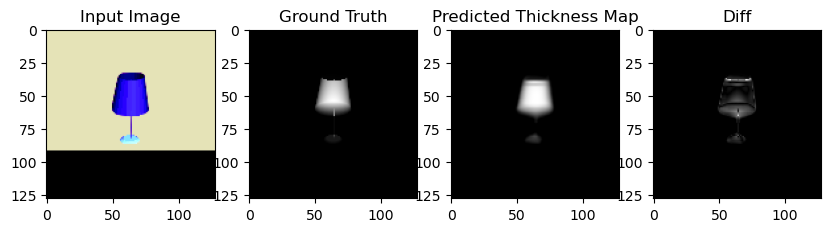

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
trained_model=model
trained_model.eval()


with torch.no_grad():
    data = iter(train_dataloader).next()
    image, label = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
    output = trained_model(image)
    image = image.cpu().numpy().transpose(0,2,3,1)
    label = label.cpu().numpy()
    output = output.cpu().numpy()

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1,4,2)
    plt.imshow(label[0].reshape(128,128), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,4,3)
    plt.imshow(output[0].reshape(128,128), cmap='gray')
    plt.title('Predicted Thickness Map')
    plt.subplot(1,4,4)
    plt.imshow(abs(label[0]-output[0]).reshape(128,128), cmap='gray')
    plt.title('Diff')
    plt.show()

